In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
from keras_preprocessing.image import ImageDataGenerator

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')
test_ds = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

Found 2641 images belonging to 3 classes.
Found 660 images belonging to 2 classes.


In [5]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.LeakyReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [6]:
print("building the involution model...")

inputs = keras.Input(shape=(150, 150, 3))
x,_ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
#112,112,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.LeakyReLU()(x)
#56,56,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.LeakyReLU()(x)
x, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=2, name="inv_4"
)(x)

x = keras.layers.LeakyReLU()(x)
#28,28,3
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="leaky_relu")(x)
outputs = keras.layers.Dense(2)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=100, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Users\gunav\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\gunav\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\gunav\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\gunav\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\gunav\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\gunav\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\gunav\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\gunav\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\gunav\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\gunav\AppData\Local\Temp\ipykernel_26508\3949292959.py", line 42, in <cell line: 42>
      inv_hist = inv_model.fit(train_ds, epochs=100, validation_data=test_ds)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Users\gunav\anaconda3\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[64,2] labels_size=[64,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_2841]

In [37]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_4 (Involution)          ((None, 150, 150, 3),     58        
                              (None, 150, 150, 25, 1,            
                              1))                                
                                                                 
 softmax_3 (Softmax)         (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 3)        0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

building the involution model...
compiling the involution model...
inv model training...


IndexError: tuple index out of range

In [38]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_4 (Involution)          ((None, 150, 150, 3),     58        
                              (None, 150, 150, 25, 1,            
                              1))                                
                                                                 
 softmax_3 (Softmax)         (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 3)        0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [39]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_4 (Involution)          ((None, 150, 150, 3),     58        
                              (None, 150, 150, 25, 1,            
                              1))                                
                                                                 
 softmax_3 (Softmax)         (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 3)        0         
 2D)                                                             
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [40]:
inv_model(np.zeros((1, 8001, 1)))

ValueError: Input 0 of layer "inv_model" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(1, 8001, 1)

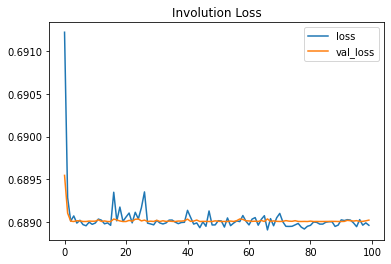

In [41]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

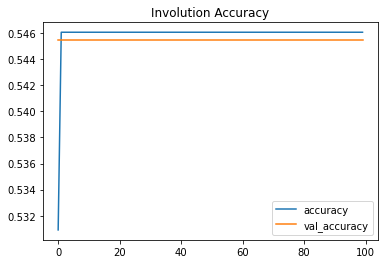

In [42]:
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

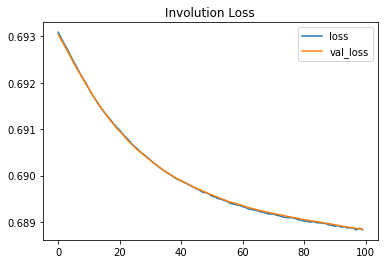

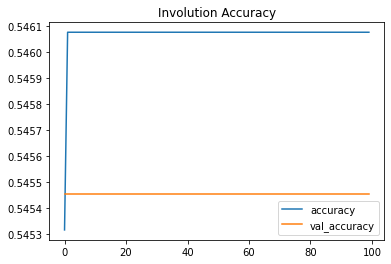

In [22]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

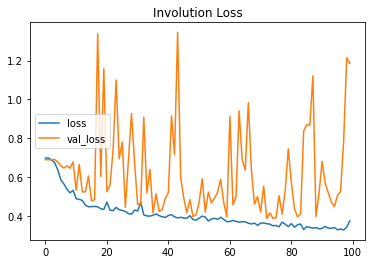

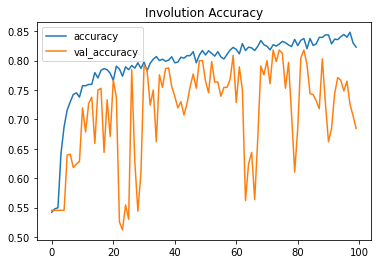

In [17]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

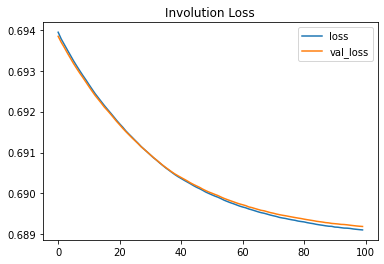

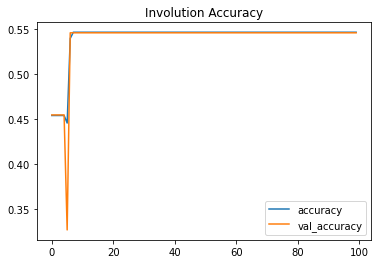

In [52]:
# Softmax 4 layers, 3x3
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

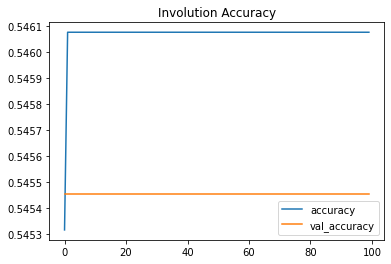

In [23]:
# 
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

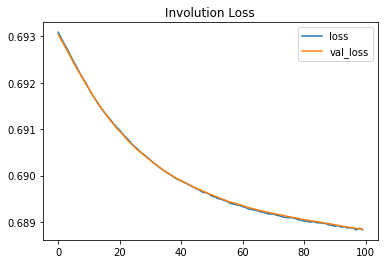

In [24]:
# Relu 0.0005lr, 4 layers
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

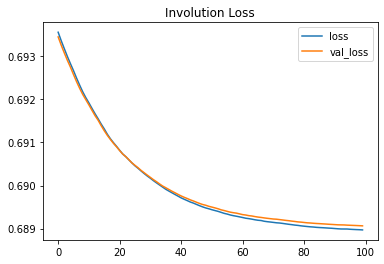

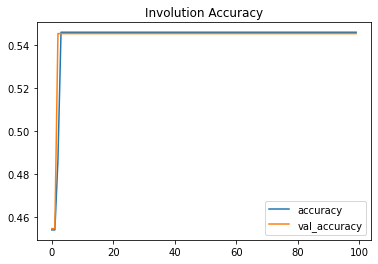

In [71]:
#RELU, 4layers, 3x3
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [72]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    l[i] = inv_hist.history["val_loss"][i] - inv_hist.history["loss"][i]
    a[i] = inv_hist.history["accuracy"][i] - inv_hist.history["val_accuracy"][i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+inv_hist.history["accuracy"][i]
    sl1 = sl1+inv_hist.history["loss"][i]
    sa2 = sa2+inv_hist.history["val_accuracy"][i]
    sl2 = sl2+inv_hist.history["val_loss"][i]

In [73]:
#Avg Difference in Accuracy
print(sa/100)

3.483891487121582e-07


In [74]:
#Avg Difference in Loss
sl/100

3.767669200897217e-05

In [75]:
#Avg Train Accuracy
sa1

54.36367282271385

In [76]:
#Avg Test Accuracy
sa2

54.36363798379898

In [77]:
#Avg Train Loss
sl1/100

0.6899844026565551

In [78]:
#Avg Test Loss
sl2/100

0.6900220793485642

In [79]:
df = pd.DataFrame(inv_hist.history["val_accuracy"])

In [80]:
df.max()

0    0.545455
dtype: float64